In [1]:
!pip install tqdm
!apt-get install unrar -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
!unrar x UTKFace.rar

Streaming output truncated to the last 5000 lines.
Extracting  UTKFace/53_0_1_20170116192938845.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_1_20170117181950281.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_1_20170120222553113.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_1_20170120222956787.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_1_20170120223004304.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20170104210010763.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20170112215433623.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20170112221930338.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20170116192925824.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20170116192934154.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import csv
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers,models,Sequential
from tensorflow.keras.models import load_model
import gc
gc.collect()

5

In [4]:
image_folder = "UTKFace"

In [5]:
csv_file = "face_labels.csv"

In [6]:
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'age', 'gender'])

    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            try:
                age, gender, *_ = filename.split("_")
                writer.writerow([filename, age, gender])
            except ValueError:
                print("Skipping file with unexpected format:", filename)

print(f"CSV file created: {csv_file}")

CSV file created: face_labels.csv


In [7]:
df=pd.read_csv('face_labels.csv')
df.sample(5)

,image_name,age,gender
456,36_0_0_20170104174512284.jpg.chip.jpg,36,0
9193,49_1_0_20170103181021153.jpg.chip.jpg,49,1
11857,8_1_4_20170103210016155.jpg.chip.jpg,8,1
18786,10_0_4_20170103201924664.jpg.chip.jpg,10,0
6901,28_1_3_20170117180631161.jpg.chip.jpg,28,1


(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

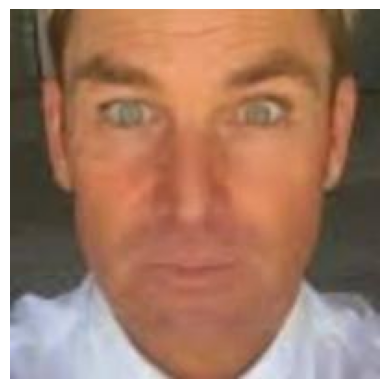

In [8]:
image_path = os.path.join(image_folder, df.image_name[1000])
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')

In [9]:
df.shape

(23708, 3)

In [10]:
img = cv2.imread(os.path.join(image_folder, df.image_name[1000]))
print("Shape:", img.shape)

Shape: (200, 200, 3)


array([[[ 47,  67,  72],
        [ 44,  64,  69],
        [ 44,  65,  67],
        ...,
        [ 51,  65,  64],
        [ 50,  64,  63],
        [ 49,  63,  62]],

       [[ 48,  68,  73],
        [ 45,  65,  70],
        [ 45,  66,  68],
        ...,
        [ 51,  65,  64],
        [ 50,  64,  63],
        [ 50,  64,  63]],

       [[ 49,  68,  73],
        [ 46,  65,  70],
        [ 45,  64,  67],
        ...,
        [ 51,  65,  64],
        [ 51,  65,  64],
        [ 51,  65,  64]],

       ...,

       [[173, 145, 144],
        [176, 148, 147],
        [181, 153, 152],
        ...,
        [178, 161, 164],
        [174, 157, 160],
        [172, 155, 158]],

       [[168, 140, 139],
        [171, 143, 142],
        [177, 149, 148],
        ...,
        [181, 164, 167],
        [180, 163, 166],
        [179, 162, 165]],

       [[165, 137, 136],
        [169, 141, 140],
        [175, 147, 146],
        ...,
        [183, 166, 169],
        [183, 166, 169],
        [184, 167, 170]]], dtype=uint8)
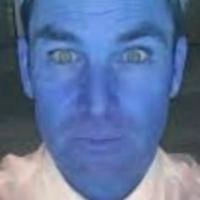

In [11]:
img

In [12]:
def reshape_img(image_folder,image_name):
    img = cv2.imread(os.path.join(image_folder,image_name))
    img_resized = cv2.resize(img, (200,200))
    return img_resized/255

In [13]:
X=df.drop(['age'],axis='columns')
Y=df.age

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [15]:
X_gen_det=X_train.drop(['gender'],axis='columns')
X_gen_det.head()

,image_name
19654,72_0_2_20170112223906858.jpg.chip.jpg
3663,50_1_0_20170110123120845.jpg.chip.jpg
3997,26_1_3_20170119155434898.jpg.chip.jpg
11803,24_1_1_20170113003543637.jpg.chip.jpg
8728,27_0_4_20170117202219111.jpg.chip.jpg


In [16]:
Y_gen_det=X_train.gender
Y_gen_det.head()

,gender
19654,0
3663,1
3997,1
11803,1
8728,0


In [17]:
X_gen_det.image_name.shape

(18966,)

In [18]:
def compute(cnn_gender, X_gen_det_img, Y_gen_det_batch):
    cnn_gender.fit(np.array(X_gen_det_img), np.array(Y_gen_det_batch), epochs=5, batch_size=32)
    return cnn_gender

In [19]:
img_height=img_width=200
data_aug = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.3),
])

In [20]:
if os.path.exists("gender_model.h5"):
    model = load_model("gender_model.h5")
    print("Loaded saved model.")
else:
    cnn_gender=Sequential([
      data_aug,
      #cnn
      layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=(200,200,3)),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      #dense
      layers.Flatten(),
      layers.Dense(256,activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128,activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(64,activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1,activation='sigmoid')
    ])
    cnn_gender.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
def preprocess(X_gen_det,image_folder,x,y):
    X_gen_det_img=[]
    for image_name in tqdm(X_gen_det.image_name[x:y], desc="Processing images"):
        try:
            img = reshape_img(image_folder, image_name)
            X_gen_det_img.append(img)
        except Exception as e:
            print(f"Skipping {image_name}: {e}")
    return X_gen_det_img

In [22]:
def np_conversion(cnn_gender, X_gen_det_img, Y_gen_det_batch):
    X_gen_det_img = np.array(X_gen_det_img)
    Y_gen_det_batch = np.array(Y_gen_det_batch)
    cnn_gender = compute(cnn_gender, X_gen_det_img, Y_gen_det_batch)
    return cnn_gender

In [23]:
done = 0
while done < X_gen_det.image_name.shape[0]:
    end = min(done + 2000, X_gen_det.image_name.shape[0])
    X_gen_det_img = preprocess(X_gen_det, image_folder, done, end)
    cnn_gender = np_conversion(cnn_gender, X_gen_det_img, Y_gen_det[done:end])
    cnn_gender.save("gender_model.h5")
    print(f"Saved model after batch {done}-{end}")
    done = end
    # Clean up RAM (without clearing model session)
    del X_gen_det_img
    gc.collect()


Processing images: 100%|██████████| 2000/2000 [00:01<00:00, 1179.55it/s]


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.5278 - loss: 0.6931
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.6358 - loss: 0.6689
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.6686 - loss: 0.6263
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6763 - loss: 0.6039
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6624 - loss: 0.6220


Saved model after batch 0-2000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2316.08it/s]


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7059 - loss: 0.5960
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.7034 - loss: 0.5793
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7456 - loss: 0.5254
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7536 - loss: 0.5301
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.7218 - loss: 0.5712


Saved model after batch 2000-4000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2330.97it/s]


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7431 - loss: 0.5285
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7682 - loss: 0.4893
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7577 - loss: 0.5079
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7606 - loss: 0.4945
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7700 - loss: 0.4897


Saved model after batch 4000-6000


Processing images: 100%|██████████| 2000/2000 [00:01<00:00, 1843.91it/s]


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.7729 - loss: 0.4973
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7932 - loss: 0.4503
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7741 - loss: 0.4518
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7907 - loss: 0.4540
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.8069 - loss: 0.4292


Saved model after batch 6000-8000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2307.79it/s]


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7566 - loss: 0.4978
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7853 - loss: 0.4629
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7712 - loss: 0.4881
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7702 - loss: 0.4868
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.7806 - loss: 0.4762


Saved model after batch 8000-10000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2395.48it/s]


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8005 - loss: 0.4448
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8062 - loss: 0.4493
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7857 - loss: 0.4578
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.7878 - loss: 0.4578
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8264 - loss: 0.4059


Saved model after batch 10000-12000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2326.46it/s]


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.7895 - loss: 0.4709
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7926 - loss: 0.4546
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8162 - loss: 0.4226
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8017 - loss: 0.4347
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8055 - loss: 0.4201


Saved model after batch 12000-14000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2326.27it/s]


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7763 - loss: 0.4528
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7959 - loss: 0.4496
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7858 - loss: 0.4488
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7777 - loss: 0.4419
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8051 - loss: 0.4260


Saved model after batch 14000-16000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2346.18it/s]


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.7741 - loss: 0.4580
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8070 - loss: 0.4111
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8045 - loss: 0.4084
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8131 - loss: 0.4012
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8087 - loss: 0.4172


Saved model after batch 16000-18000


Processing images: 100%|██████████| 966/966 [00:00<00:00, 1876.18it/s]


Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8221 - loss: 0.3672
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8564 - loss: 0.3557
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8427 - loss: 0.3622
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.8459 - loss: 0.3380
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8480 - loss: 0.3427


Saved model after batch 18000-18966


In [24]:
X_test_gen_det=X_test.drop(['gender'],axis='columns')
X_test_gen_det.head()

,image_name
13889,63_0_0_20170113210319759.jpg.chip.jpg
7190,32_1_0_20170117134818845.jpg.chip.jpg
14622,32_1_2_20170109135854714.jpg.chip.jpg
3342,39_1_1_20170116012217327.jpg.chip.jpg
23414,45_0_3_20170119162821908.jpg.chip.jpg


In [25]:
Y_test_gen_det=X_test.gender
Y_test_gen_det.head()

,gender
13889,0
7190,1
14622,1
3342,1
23414,0


In [26]:
cnn_gender = load_model("gender_model.h5")
print("Model loaded.")

Model loaded.


In [27]:
def predict_batch(X_test_gen_det, image_folder, x, y):
    X_test_img = []
    batch_filenames = []
    for image_name in tqdm(X_test_gen_det.image_name[x:y], desc="Processing images"):
        try:
            img = reshape_img(image_folder, image_name)
            X_test_img.append(img)
            batch_filenames.append(image_name)
        except Exception as e:
            print(f"Skipping {image_name}: {e}")

    if not X_test_img:
        return [], []

    X_test_img = np.array(X_test_img)
    predictions = cnn_gender.predict(X_test_img)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    return batch_filenames, predicted_labels

In [28]:
batch_size = 2000
done = 0
all_filenames = []
all_predictions = []

while (done < X_test_gen_det.image_name.shape[0]):
    end = min(done +batch_size,X_test_gen_det.image_name.shape[0])
    print(f"image processing: {done}-{end}")
    batch_filenames, batch_preds = predict_batch(X_test_gen_det, image_folder, done, end)
    all_filenames.extend(batch_filenames)
    all_predictions.extend(batch_preds)
    gc.collect()
    done = end

image processing: 0-2000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2276.62it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
image processing: 2000-4000


Processing images: 100%|██████████| 2000/2000 [00:01<00:00, 1669.37it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
image processing: 4000-4742


Processing images: 100%|██████████| 742/742 [00:00<00:00, 2262.50it/s]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [29]:
all_predictions= np.array(all_predictions, dtype=int)
all_predictions

array([0, 1, 0, ..., 1, 1, 1])

In [30]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_gen_det, all_predictions))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2430
           1       0.84      0.78      0.81      2312

    accuracy                           0.82      4742
   macro avg       0.82      0.82      0.82      4742
weighted avg       0.82      0.82      0.82      4742



In [31]:
#age model code starts:

In [32]:
def compute(cnn_age, X_test, Y_test):
    cnn_age.fit(np.array(X_test), np.array(Y_test), epochs=10, batch_size=32)
    return cnn_age

In [33]:
def np_conversion_age(cnn_age, X_gen_det_img, Y_gen_det_batch):
    X_gen_det_img = np.array(X_gen_det_img)
    Y_gen_det_batch = np.array(Y_gen_det_batch)
    cnn_age = compute(cnn_age, X_gen_det_img, Y_gen_det_batch)
    return cnn_age

In [34]:
if os.path.exists("age_model.h5"):
    age_model = load_model("age_model.h5")
    print("Loaded saved model.")
else:
    print("Creating model: ")
    cnn_age=Sequential([
      data_aug,
      #cnn
      layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=(200,200,3)),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      #dense
      layers.Flatten(),
      layers.Dense(1000,activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(500,activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(200,activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(23,activation='softmax')
    ])
    cnn_age.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Creating model: 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
import numpy as np
from tensorflow.keras.utils import to_categorical

def bin_age_labels(ages, bin_width=5, max_age=115):
    bins = np.arange(0, max_age + bin_width, bin_width)
    binned_labels = np.digitize(ages, bins, right=False) - 1
    binned_labels = np.clip(binned_labels, 0, len(bins) - 2)
    return binned_labels

Y_age_binned = bin_age_labels(Y_train)
Y_age_cat_23 = to_categorical(Y_age_binned, 23)

In [48]:
Y_age_cat_23.shape

(18966, 23)

In [37]:
done = 0
while done < X_train.image_name.shape[0]:
    end = min(done + 1000, X_train.image_name.shape[0])
    X_gen_det_img = preprocess(X_train, image_folder, done, end)
    cnn_age = np_conversion_age(cnn_age, X_gen_det_img, Y_age_cat_23[done:end])
    cnn_age.save("age_model.h5")
    print(f"Saved model after batch {done}-{end}")
    done = end
    # Clean up RAM
    del X_gen_det_img
    gc.collect()


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2249.64it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.1859 - loss: 2.8369
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2504 - loss: 2.6234
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.2315 - loss: 2.6238
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.2180 - loss: 2.5684
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2290 - loss: 2.5922
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2395 - loss: 2.6193
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.2511 - loss: 2.5549
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.2393 - loss: 2.5503
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.2551 - loss: 2.5141
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2376 - loss: 2.4838


Saved model after batch 0-1000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2383.85it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.1992 - loss: 2.6217
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.1867 - loss: 2.6023
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1918 - loss: 2.5453
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2401 - loss: 2.4735
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2578 - loss: 2.4642
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2355 - loss: 2.4452
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2303 - loss: 2.4708
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2460 - loss: 2.3715
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2437 - loss: 2.3896
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2712 - loss: 2.3613


Saved model after batch 1000-2000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2260.54it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2687 - loss: 2.4249
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.2612 - loss: 2.4066
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2864 - loss: 2.2913
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2975 - loss: 2.2536
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2764 - loss: 2.3183
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2855 - loss: 2.2052
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.2746 - loss: 2.2541
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2867 - loss: 2.1901
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2812 - loss: 2.2545
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2896 - loss: 2.2392


Saved model after batch 2000-3000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2278.93it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2756 - loss: 2.3334
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2928 - loss: 2.2139
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2432 - loss: 2.2577
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2801 - loss: 2.1853
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2658 - loss: 2.2311
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.2762 - loss: 2.1987
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2669 - loss: 2.2215
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2896 - loss: 2.1612
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2769 - loss: 2.1362
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3049 - loss: 2.1167


Saved model after batch 3000-4000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 1838.67it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2640 - loss: 2.2677
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2606 - loss: 2.2471
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2596 - loss: 2.2473
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2652 - loss: 2.2218
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2901 - loss: 2.2449
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2857 - loss: 2.2154
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2862 - loss: 2.1984
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2877 - loss: 2.1532
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2782 - loss: 2.1312
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.3079 - loss: 2.0675


Saved model after batch 4000-5000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2252.19it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3306 - loss: 2.1533
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3100 - loss: 2.1470
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3437 - loss: 2.1150
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3103 - loss: 2.1367
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3451 - loss: 2.0568
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3111 - loss: 2.1047
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3203 - loss: 2.0788
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3322 - loss: 1.9866
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3286 - loss: 1.9562
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3324 - loss: 2.0296


Saved model after batch 5000-6000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2328.49it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3063 - loss: 2.2043
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3223 - loss: 2.0695
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3256 - loss: 2.0788
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3225 - loss: 2.0246
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3204 - loss: 2.0372
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3060 - loss: 2.0570
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3161 - loss: 2.0445
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3294 - loss: 2.0321
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3531 - loss: 1.9552
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3084 - loss: 1.9963


Saved model after batch 6000-7000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2350.39it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2873 - loss: 2.1248
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3237 - loss: 1.9939
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3145 - loss: 2.0562
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3203 - loss: 1.9639
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3274 - loss: 1.9153
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3380 - loss: 1.9690
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3334 - loss: 1.8806
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3486 - loss: 2.0173
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3283 - loss: 1.9913
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3287 - loss: 1.9455


Saved model after batch 7000-8000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2250.18it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3054 - loss: 2.1185
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3346 - loss: 1.9922
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3125 - loss: 2.0605
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3322 - loss: 1.9571
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3557 - loss: 1.9347
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3517 - loss: 1.8991
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.2938 - loss: 2.0146
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3165 - loss: 2.0529
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3030 - loss: 2.0438
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3413 - loss: 1.8992


Saved model after batch 8000-9000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2387.08it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3000 - loss: 2.0072
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3298 - loss: 1.9887
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3251 - loss: 1.9968
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3397 - loss: 1.9666
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3730 - loss: 1.9087
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3498 - loss: 1.9689
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3340 - loss: 1.9450
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3469 - loss: 1.9378
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3489 - loss: 1.9532
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3591 - loss: 1.8921


Saved model after batch 9000-10000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 1852.40it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3032 - loss: 2.0853
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3272 - loss: 2.0058
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3216 - loss: 2.0461
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3089 - loss: 2.0584
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3195 - loss: 2.0141
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3160 - loss: 2.0254
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3264 - loss: 2.0230
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3154 - loss: 1.9736
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3291 - loss: 1.9798
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3306 - loss: 1.9797


Saved model after batch 10000-11000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 1985.97it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3319 - loss: 1.9695
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3652 - loss: 1.9644
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3488 - loss: 1.9733
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3502 - loss: 1.8984
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3342 - loss: 1.9281
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3705 - loss: 1.8518
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3900 - loss: 1.8366
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3752 - loss: 1.9301
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3525 - loss: 1.8641
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.3533 - loss: 1.8931


Saved model after batch 11000-12000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2343.64it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3107 - loss: 2.0100
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3205 - loss: 1.9842
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3573 - loss: 1.9500
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.3639 - loss: 1.9047
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3156 - loss: 1.9782
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3521 - loss: 1.9267
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3396 - loss: 1.8933
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3236 - loss: 1.9404
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3125 - loss: 1.9217
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3326 - loss: 1.8977


Saved model after batch 12000-13000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2401.98it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3170 - loss: 2.0357
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3475 - loss: 1.9751
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3298 - loss: 1.9799
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3283 - loss: 1.9958
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3442 - loss: 1.9183
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3910 - loss: 1.8393
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3438 - loss: 1.8812
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.3249 - loss: 1.9459
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3766 - loss: 1.8638
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3467 - loss: 1.8633


Saved model after batch 13000-14000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2356.55it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2939 - loss: 1.9845
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3710 - loss: 1.8944
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3298 - loss: 1.9717
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3449 - loss: 1.8537
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3473 - loss: 1.8842
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.3594 - loss: 1.8784
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3387 - loss: 1.8765
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3288 - loss: 1.9215
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3707 - loss: 1.7822
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3753 - loss: 1.7934


Saved model after batch 14000-15000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2392.66it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3262 - loss: 1.9604
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3167 - loss: 1.9662
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3327 - loss: 1.9591
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3274 - loss: 1.9312
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.3508 - loss: 1.8842
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3645 - loss: 1.8877
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3551 - loss: 1.8845
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3504 - loss: 1.8963
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3779 - loss: 1.7967
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3767 - loss: 1.8114


Saved model after batch 15000-16000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 1815.37it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3028 - loss: 2.0826
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3700 - loss: 1.9443
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3565 - loss: 1.9564
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3240 - loss: 1.9553
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.3690 - loss: 1.9092
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3769 - loss: 1.8707
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3625 - loss: 1.8916
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3625 - loss: 1.8334
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3466 - loss: 1.8234
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3271 - loss: 1.9031


Saved model after batch 16000-17000


Processing images: 100%|██████████| 1000/1000 [00:00<00:00, 2179.99it/s]


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3172 - loss: 2.0148
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3492 - loss: 1.9184
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3568 - loss: 1.8522
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3207 - loss: 1.9935
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3613 - loss: 1.8647
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3564 - loss: 1.8470
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3383 - loss: 1.8746
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3622 - loss: 1.8285
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3477 - loss: 1.8170
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3469 - loss: 1.8592


Saved model after batch 17000-18000


Processing images: 100%|██████████| 966/966 [00:00<00:00, 2397.81it/s]


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3227 - loss: 1.9924
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3229 - loss: 1.9081
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3292 - loss: 1.8901
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3165 - loss: 1.9060
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3599 - loss: 1.8801
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3537 - loss: 1.8192
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3339 - loss: 1.8734
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3474 - loss: 1.8296
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3605 - loss: 1.8375
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3550 - loss: 1.8839


Saved model after batch 18000-18966


In [38]:
cnn_gender = load_model("age_model.h5")
print("Model loaded.")

Model loaded.


In [39]:
def predict_batch_age(X_test_gen_det, image_folder, x, y):
    X_test_img = []
    batch_filenames = []

    for image_name in tqdm(X_test_gen_det.image_name[x:y], desc="Processing images"):
        try:
            img = reshape_img(image_folder, image_name)
            X_test_img.append(img)
            batch_filenames.append(image_name)
        except Exception as e:
            print(f"Skipping {image_name}: {e}")

    if not X_test_img:
        return [], []

    X_test_img = np.array(X_test_img)
    predictions = cnn_age.predict(X_test_img)
    predicted_labels = np.argmax(predictions, axis=1)
    return batch_filenames, predicted_labels

In [40]:
batch_size = 2000
done = 0
all_filenames = []
all_predictions = []

while (done < X_test.image_name.shape[0]):
    end = min(done +batch_size,X_test.image_name.shape[0])
    print(f"image processing: {done}-{end}")
    batch_filenames, batch_preds = predict_batch_age(X_test, image_folder, done, end)
    all_filenames.extend(batch_filenames)
    all_predictions.extend(batch_preds)
    gc.collect()
    done = end

image processing: 0-2000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2300.33it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
image processing: 2000-4000


Processing images: 100%|██████████| 2000/2000 [00:01<00:00, 1373.05it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
image processing: 4000-4742


Processing images: 100%|██████████| 742/742 [00:00<00:00, 2346.99it/s]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [55]:
all_predictions=np.array(all_predictions)
all_predictions.shape

(4742,)

In [64]:
Y_test_age_binned = bin_age_labels(Y_test)
Y_test_age_binned=np.array(Y_test_age_binned[0])
Y_test_age_binned.shape

(4742,)

In [65]:
from sklearn.metrics import classification_report
report = classification_report(Y_test_age_binned, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       451
           1       0.37      0.28      0.32       165
           2       0.29      0.29      0.29       119
           3       0.29      0.03      0.05       180
           4       0.37      0.17      0.23       480
           5       0.37      0.80      0.51      1012
           6       0.00      0.00      0.00       469
           7       0.20      0.16      0.18       457
           8       0.00      0.00      0.00       209
           9       0.12      0.21      0.15       197
          10       0.15      0.17      0.16       283
          11       0.13      0.20      0.16       184
          12       0.10      0.02      0.04       132
          13       0.14      0.18      0.16       112
          14       0.00      0.00      0.00        69
          15       0.15      0.04      0.07        70
          16       0.23      0.17      0.19        53
          17       0.19    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
